In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import os,cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tf_explain.core.grad_cam import GradCAM

In [86]:
import os
#Define Datapath
data_path = './JAFFE'
data_dir_list = os.listdir(data_path)


img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(224,224))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-jaffedbase



(213, 224, 224, 3)

In [87]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:59]=1 #29
labels[60:92]=2 #32
labels[93:124]=3 #31
labels[125:155]=4 #30
labels[156:187]=5 #31
labels[188:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

In [88]:
# convert class labels to on-hot encoding# conve 
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

In [89]:
X_train.shape

(181, 224, 224, 3)

In [90]:
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


train_generator = train_datagen.flow(X_train,y_train,batch_size = 32)     
                                  

In [93]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))


In [ ]:
# Model Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_8 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                3211296   
                                                                 
 batch_normalization_9 (Batc  (None, 32)               128       
 hNormalization)                                      

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
model.compile(optimizer="Adam", loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_generator,validation_data=(X_test,y_test),epochs = 100,verbose = 1)

Epoch 1/100
6/6 [==============================] - 8s 450ms/step - loss: 2.2069 - accuracy: 0.8485 - precision: 0.0769 - recall: 0.0055 - auc: 0.5112 - f1_score: 0.0095 - val_loss: 2.4063 - val_accuracy: 0.8527 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3834 - val_f1_score: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 1s 185ms/step - loss: 2.1351 - accuracy: 0.8564 - precision: 0.4545 - recall: 0.0276 - auc: 0.5297 - f1_score: 0.0581 - val_loss: 4.3527 - val_accuracy: 0.7232 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3834 - val_f1_score: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 1s 190ms/step - loss: 2.1170 - accuracy: 0.8524 - precision: 0.2857 - recall: 0.0221 - auc: 0.5326 - f1_score: 0.0384 - val_loss: 6.0083 - val_accuracy: 0.7143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4062 - val_f1_score: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 1s 191ms/step - loss: 

### Quantitative Evaluation

In [ ]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.86
Train Loss:  1.69
Train Precision:  0.79
Train Recall:  0.06
Train F1-Score:  0.1


In [ ]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.72
Test Loss:  5.22
Test Precision:  0.0
Test Recall:  0.0
Test F1-Score:  0.0


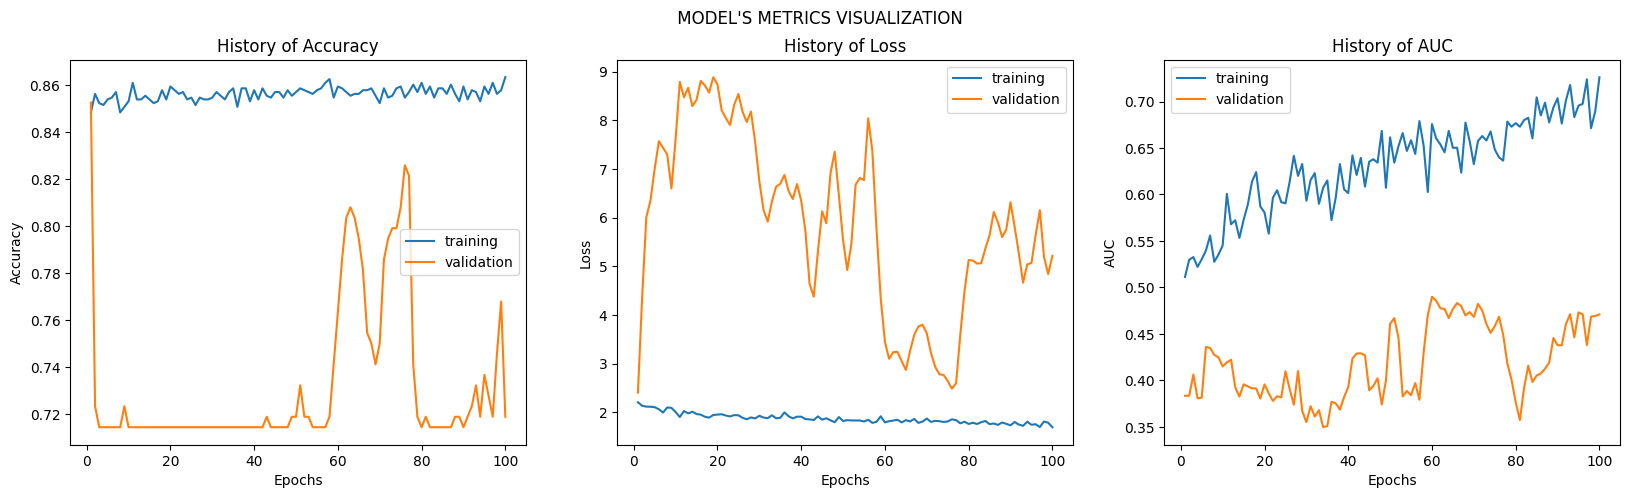

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
             
              )

###  Hyperparameter tuning


In [ ]:
epochs = 150
callbacks = [ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10),ModelCheckpoint('Jaffe.h5')]
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('Jaffe.h5')

es = EarlyStopping(verbose=1, patience=20)


In [ ]:
model.compile(optimizer="Adam", loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_generator,validation_data=(X_test,y_test),epochs = 100,verbose = 1,callbacks=callbacks)

Epoch 1/100
6/6 [==============================] - 53s 5s/step - loss: 1.8147 - accuracy: 0.8317 - precision: 0.0682 - recall: 0.0141 - auc: 0.5972 - f1_score: 0.0338 - val_loss: 7.6763 - val_accuracy: 0.7188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4539 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 355ms/step - loss: 1.7779 - accuracy: 0.8587 - precision: 0.6000 - recall: 0.0331 - auc: 0.6858 - f1_score: 0.0635 - val_loss: 9.7430 - val_accuracy: 0.7143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3847 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 312ms/step - loss: 1.7199 - accuracy: 0.8658 - precision: 0.8667 - recall: 0.0718 - auc: 0.6991 - f1_score: 0.1332 - val_loss: 11.2142 - val_accuracy: 0.7143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3911 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==================

### Quantitative Evaluation

In [ ]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.86
Train Loss:  1.65
Train Precision:  0.59
Train Recall:  0.09
Train F1-Score:  0.15


In [ ]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.86
Test Loss:  1.51
Test Precision:  0.5
Test Recall:  0.19
Test F1-Score:  0.27


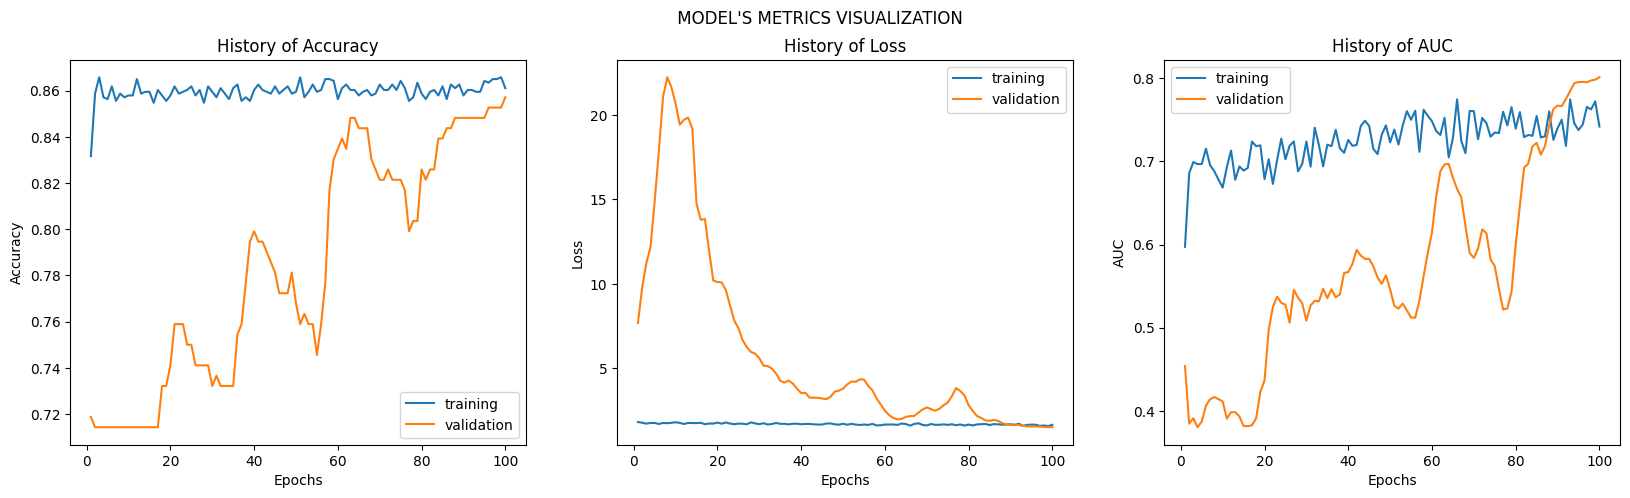

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
             
              )

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(np.where(y_test == 1)[1],Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], fontdict={'fontsize':10})
plt.show()

### Qualitative Evaluation

Test Loss: 1.5086820125579834
Test accuracy: 0.8571428656578064
(1, 224, 224, 3)
1/1 [==============================] - 5s 5s/step
[[0.06194257 0.05655154 0.3064915  0.00656736 0.5043986  0.0403346
  0.02371391]]
1/1 [==============================] - 0s 73ms/step
[[0. 0. 0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 87ms/step


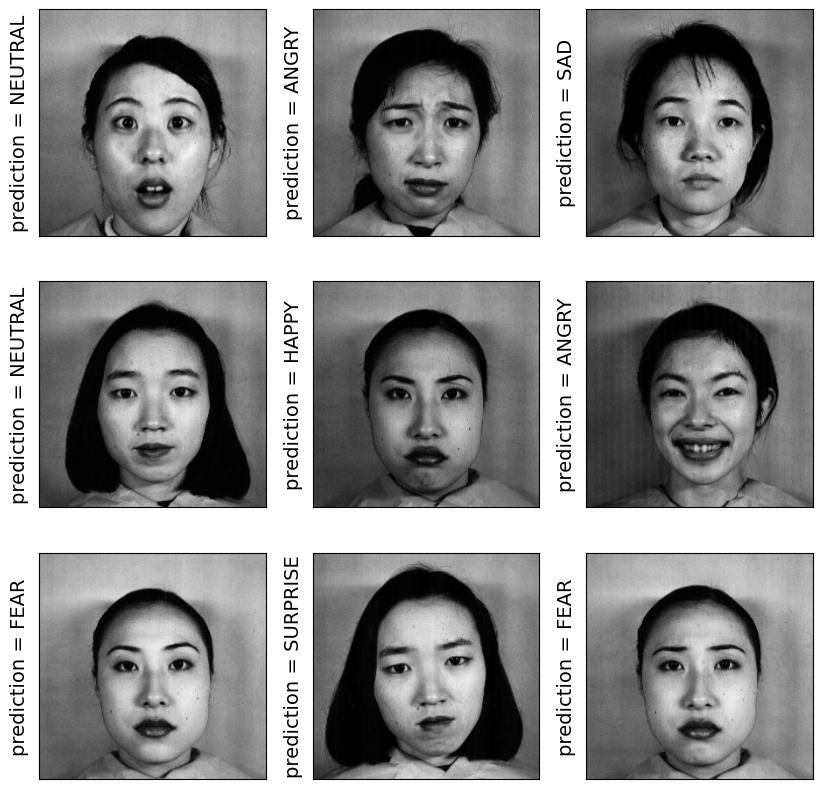

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
classes_x = np.argmax(model.predict(test_image),axis=1)
print(y_test[0:1])

res = np.argmax(model.predict(X_test[0:9]),axis=1)
plt.figure(figsize = (10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap = plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
    
# show the plot
plt.show()